In [1]:
from numpy.random import seed
from compute_rmse import compute_rmse as rmse
from tensorflow import keras
from keras import backend as K, callbacks, layers
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf

print("Tensorflow version: " + tf.__version__)
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=14, titlepad=10)
%matplotlib inline
warnings.filterwarnings('ignore')
seed(42)
tf.random.set_seed(42)


Tensorflow version: 2.10.0


Data input


In [2]:
df = pd.read_csv('input/train.csv', sep = ';')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6714 entries, 0 to 6713
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6714 non-null   float64
 1   volatile acidity      6714 non-null   float64
 2   citric acid           6714 non-null   float64
 3   residual sugar        6714 non-null   float64
 4   chlorides             6714 non-null   float64
 5   free sulfur dioxide   6714 non-null   int64  
 6   total sulfur dioxide  6714 non-null   int64  
 7   density               6714 non-null   float64
 8   pH                    6714 non-null   float64
 9   sulphates             6714 non-null   float64
 10  alcohol               6714 non-null   float64
 11  quality               6714 non-null   int64  
 12  type                  6714 non-null   object 
dtypes: float64(9), int64(3), object(1)
memory usage: 682.0+ KB


In [4]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,6.6,0.3,0.36,1.2,0.035,43,126,0.9909,3.01,0.63,11.4,6,white
1,7.7,0.5,0.26,1.9,0.062,9,31,0.9966,3.39,0.64,9.6,5,red
2,8.4,0.5,0.35,2.9,0.076,21,127,0.9976,3.23,0.63,9.2,5,red
3,7.5,0.4,0.33,5.0,0.045,30,131,0.9942,3.32,0.44,10.9,6,white
4,6.4,0.2,0.25,20.2,0.083,35,157,0.9998,3.17,0.50,9.1,5,white


In [5]:
df.isnull().values.any()

False

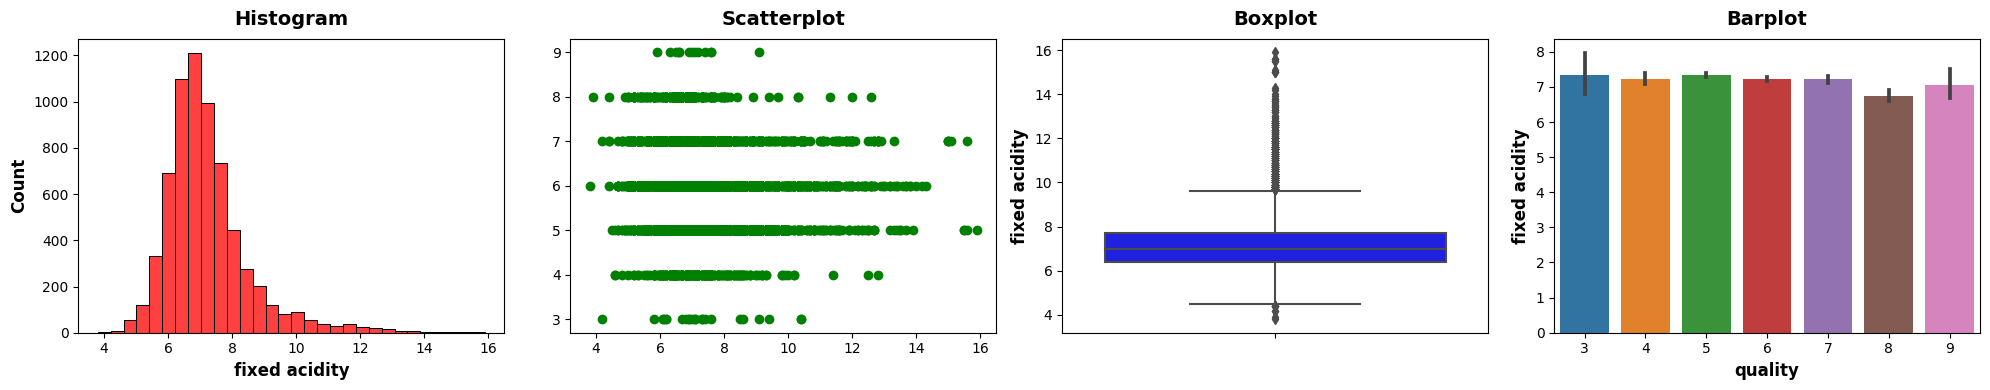

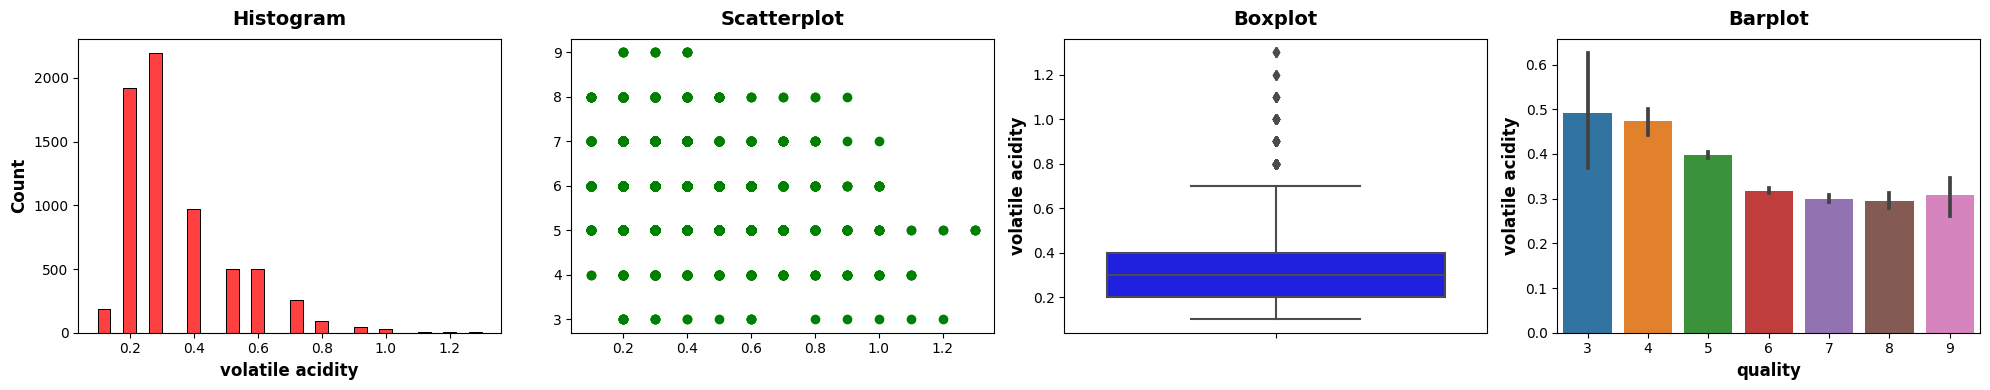

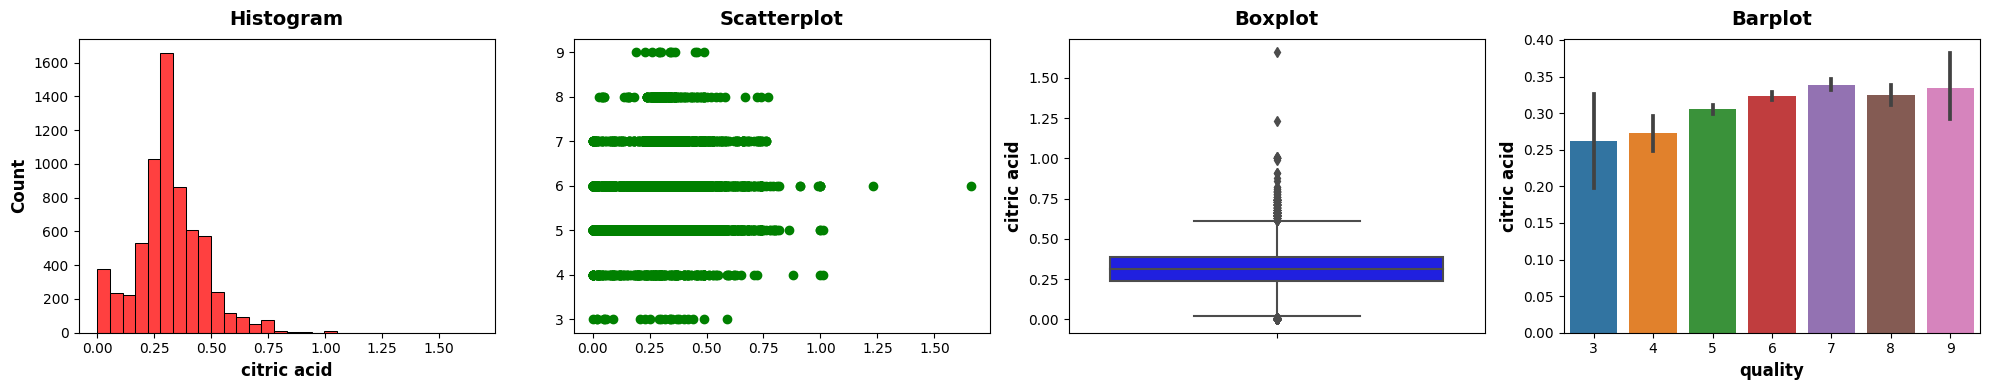

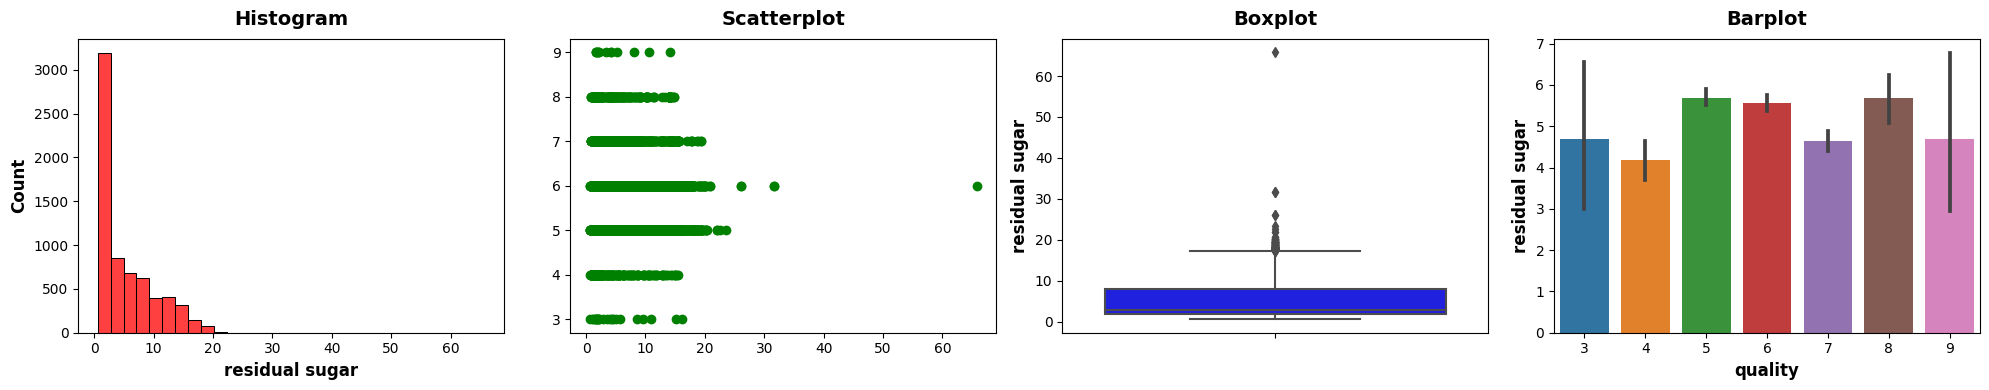

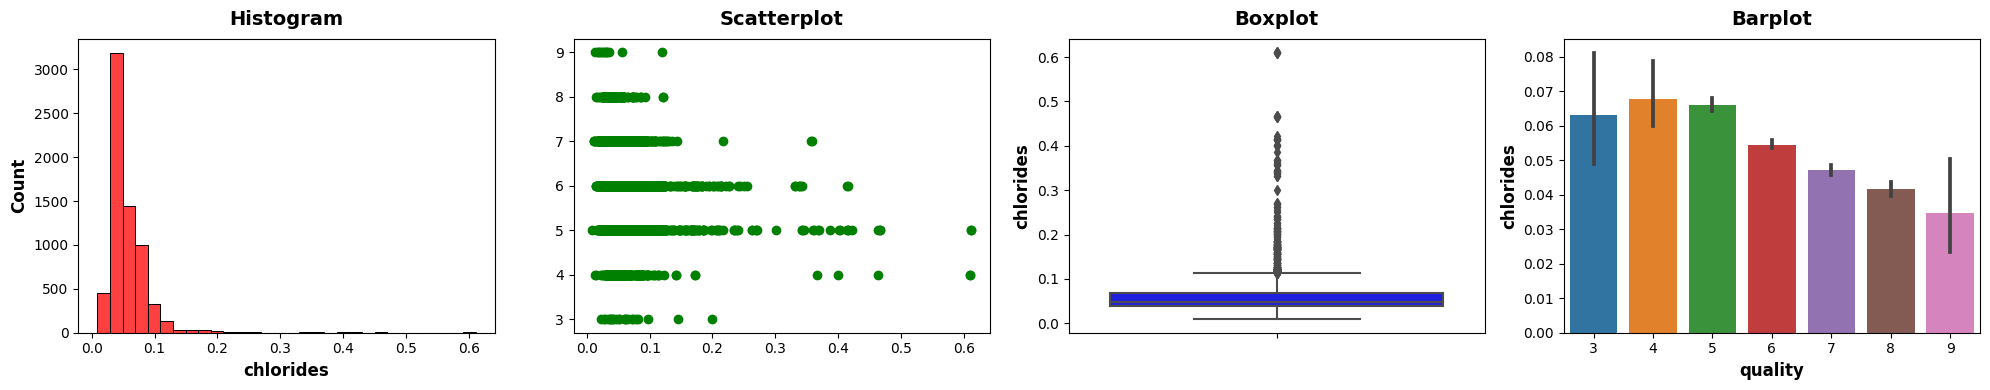

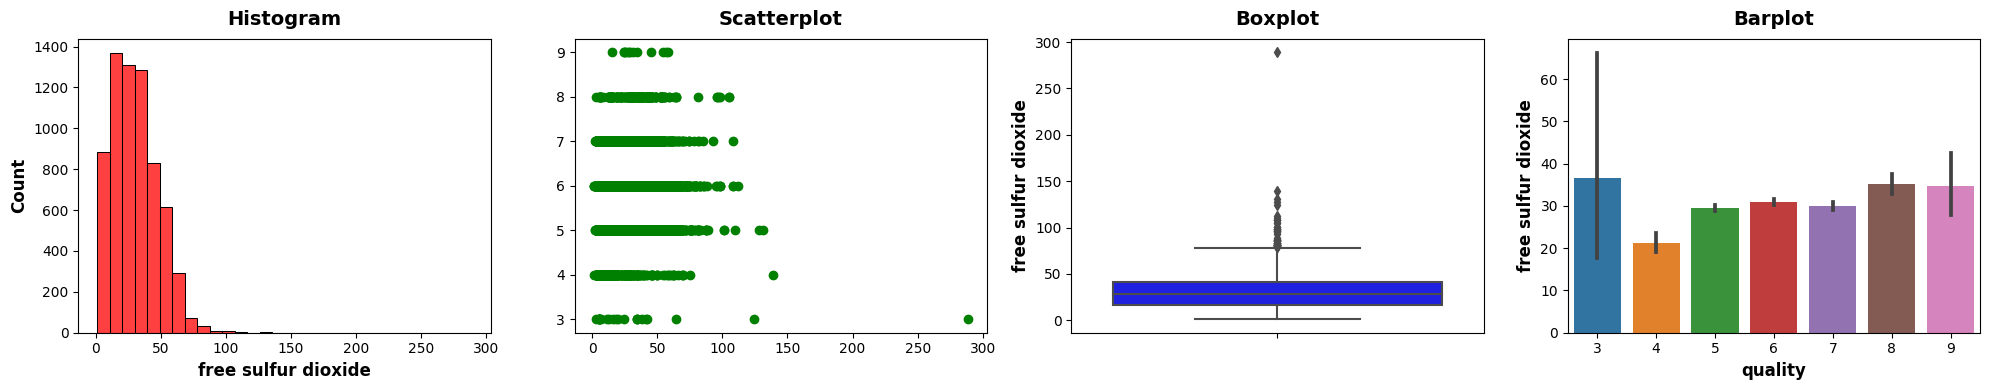

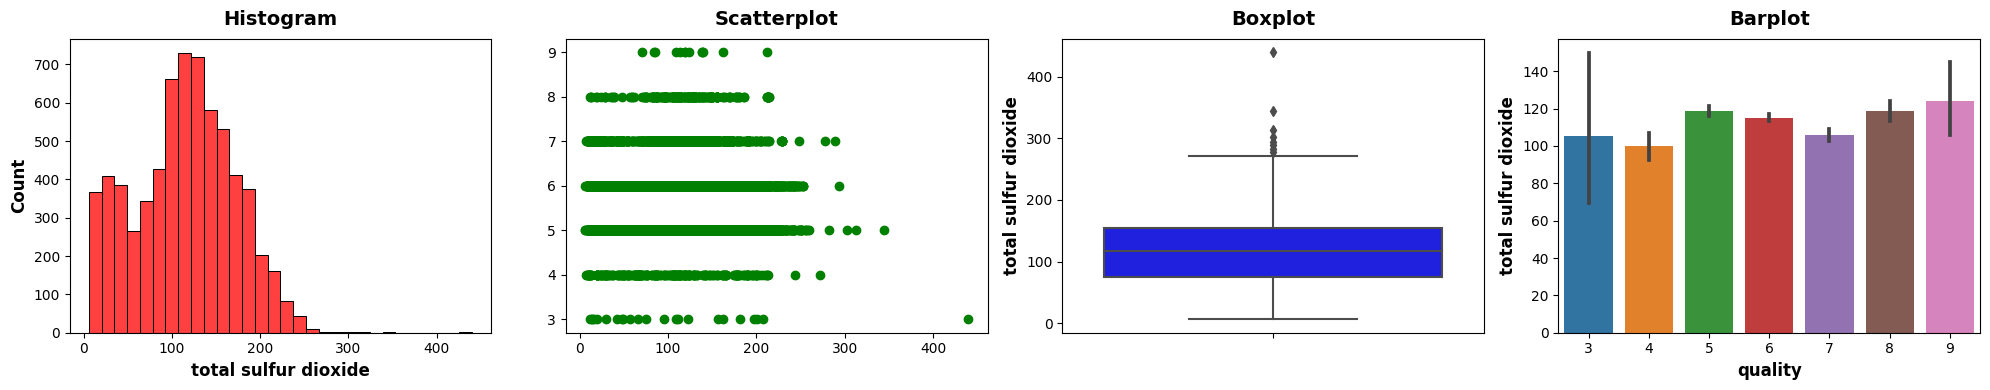

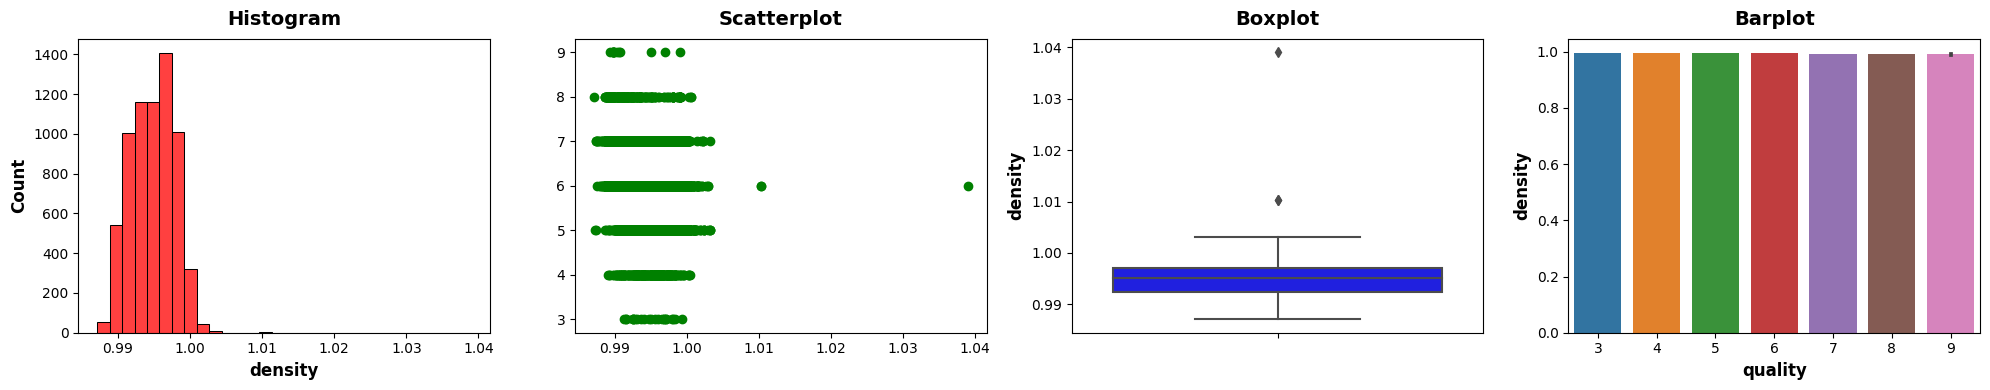

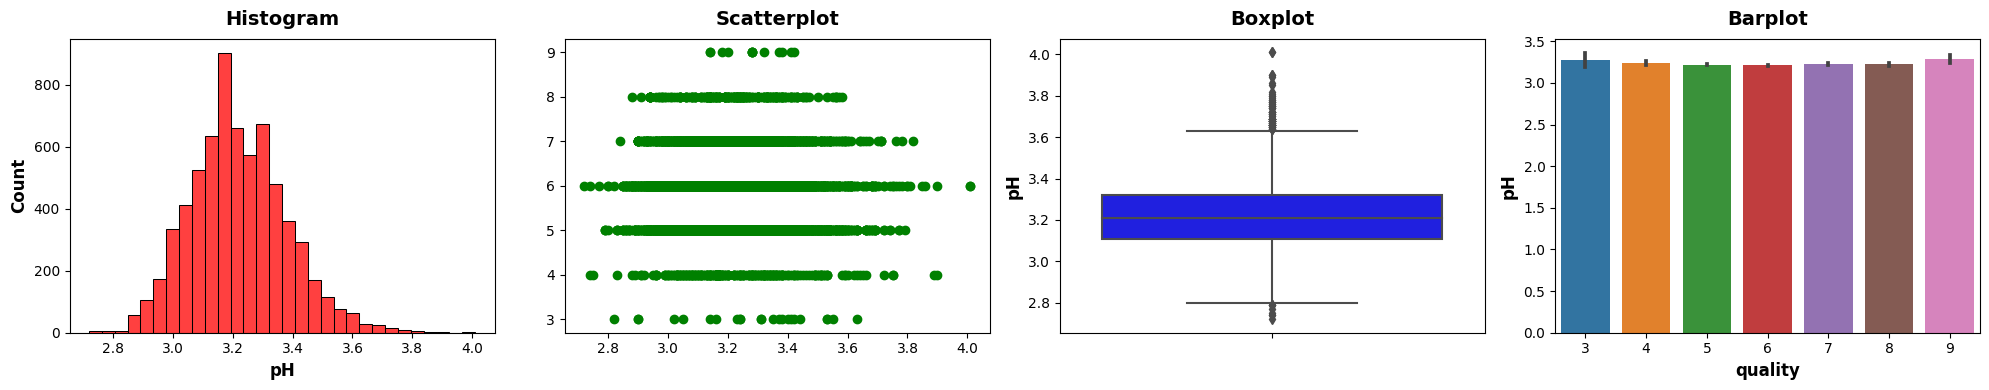

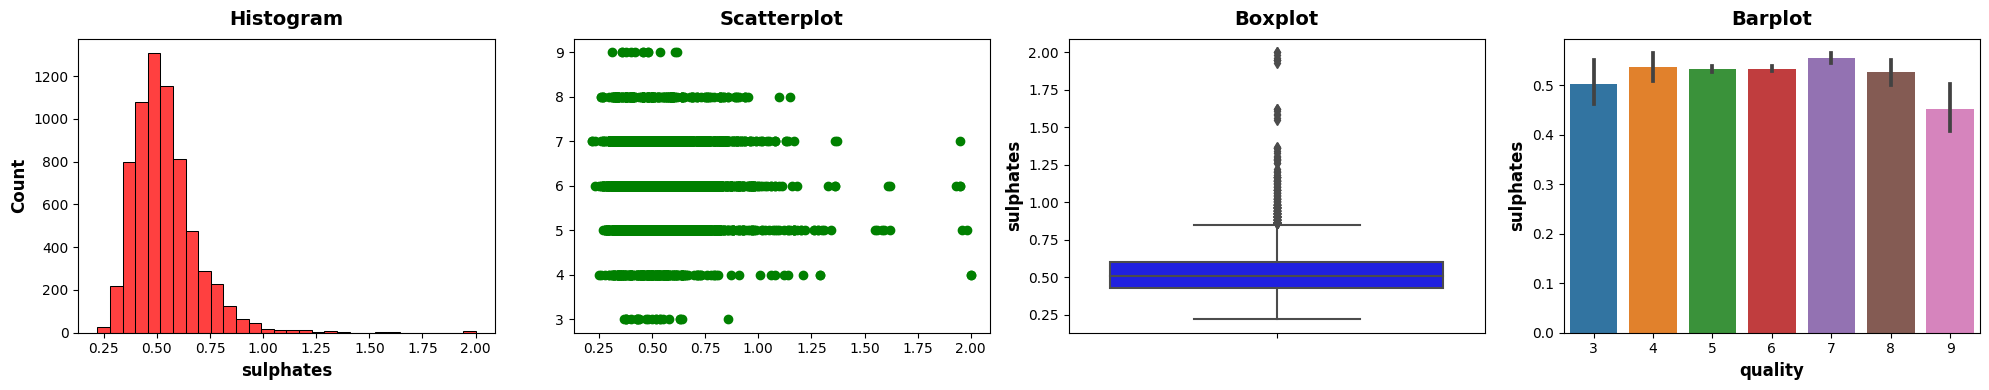

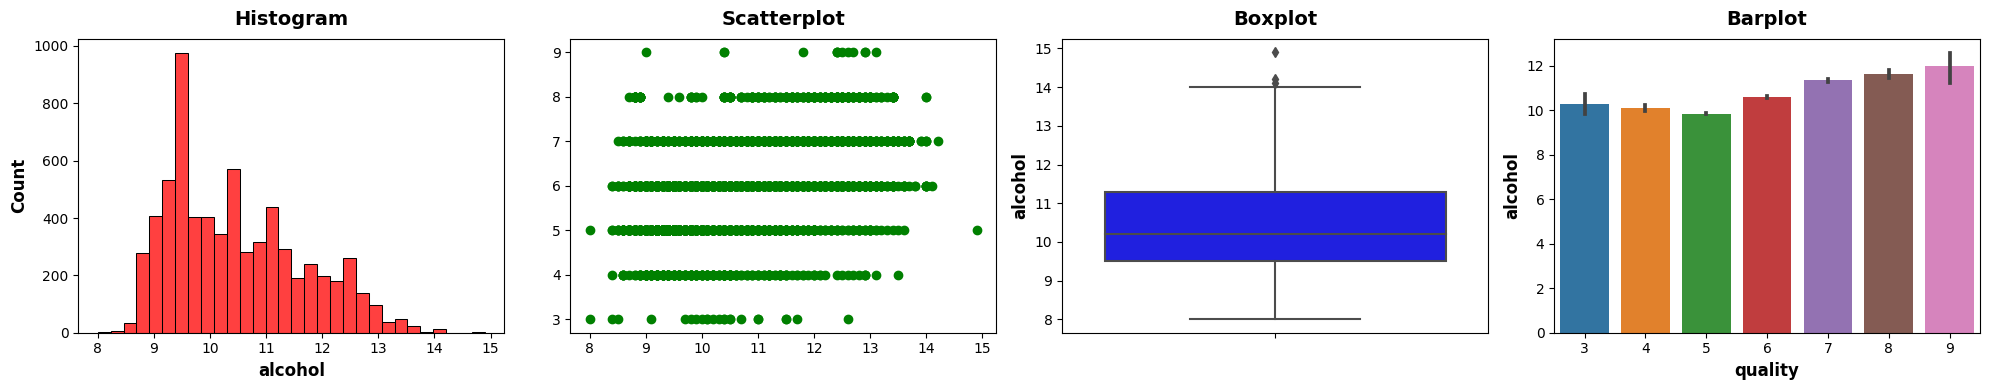

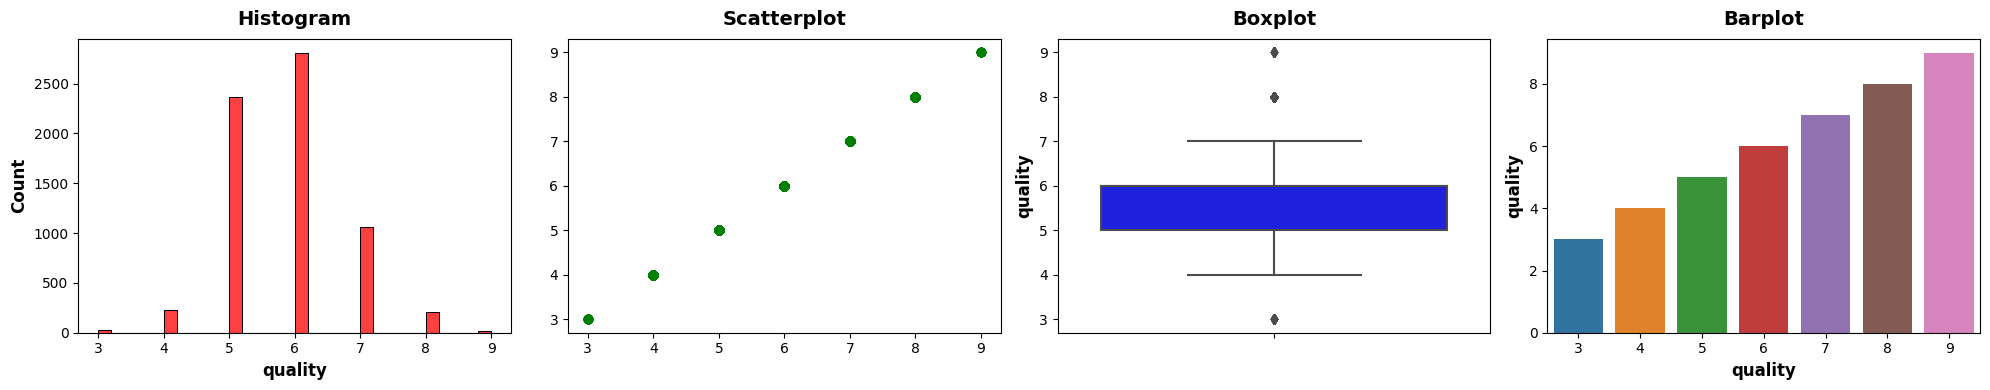

In [6]:
def diagnostic_plots(df, variable,target):
    # The function takes a dataframe (df) and
    # the variable of interest as arguments.

    # Define figure size.
    plt.figure(figsize=(20, 4))

    # histogram
    plt.subplot(1, 4, 1)
    sns.histplot(df[variable], bins=30,color = 'r')
    plt.title('Histogram')


    # scatterplot
    plt.subplot(1, 4, 2)
    plt.scatter(df[variable],df[target],color = 'g')
    plt.title('Scatterplot')
    
    
    # boxplot
    plt.subplot(1, 4, 3)
    sns.boxplot(y=df[variable],color = 'b')
    plt.title('Boxplot')
    
    # barplot
    plt.subplot(1, 4, 4)
    sns.barplot(x = target, y = variable, data = df)   
    plt.title('Barplot')
    
    
    plt.show()
for variable in df.drop('type', axis = 1):
    diagnostic_plots(df,variable,'quality')

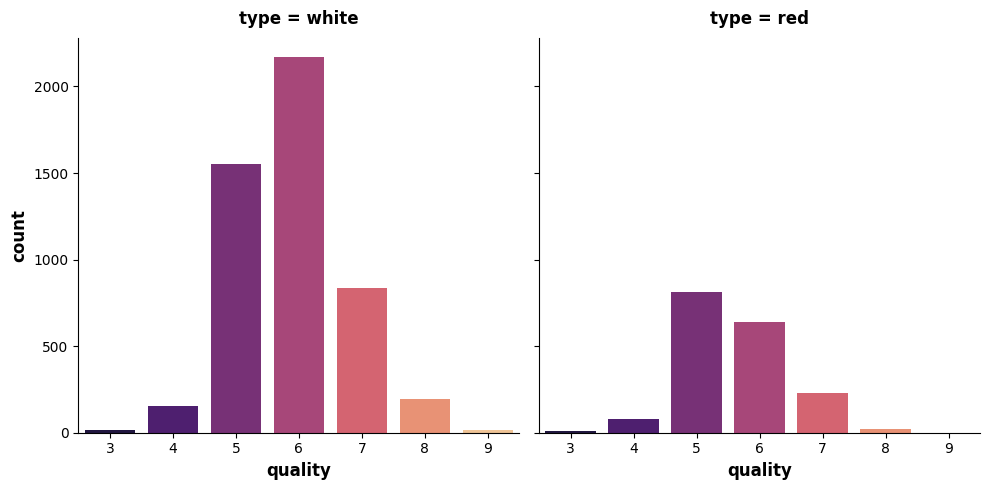

In [8]:
sns.catplot(x='quality', col = 'type', kind='count', data=df, palette = 'magma')


<AxesSubplot: >

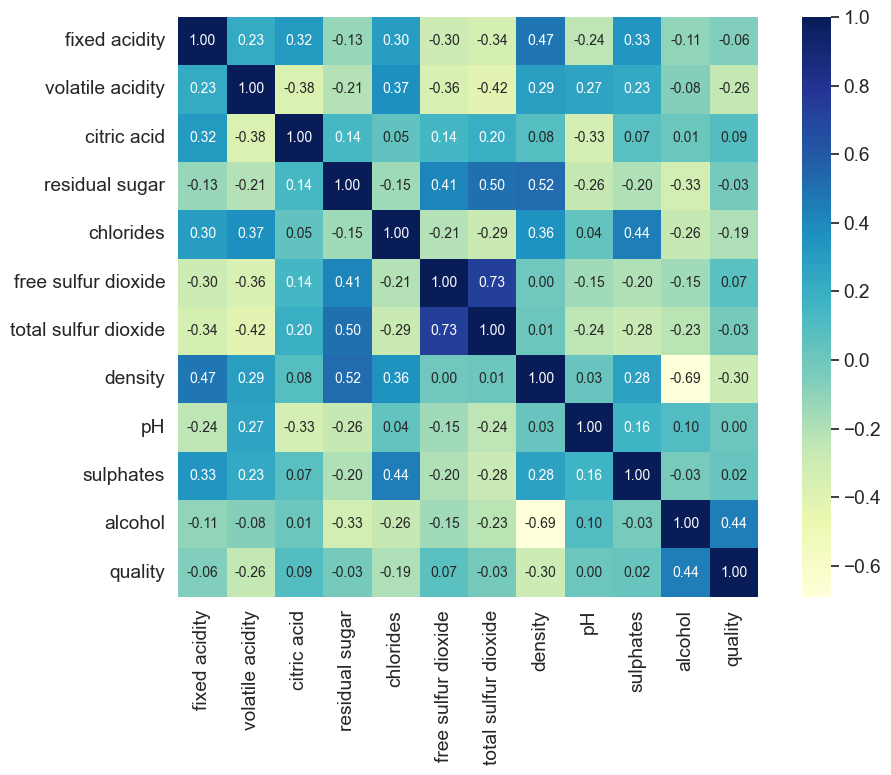

In [14]:
plt.figure(figsize = (10,8))
sns.set(font_scale=1.25)
sns.heatmap(df.corr(), cmap = 'YlGnBu', cbar_kws = {'shrink': 1}, annot = True, cbar = True, fmt = '.2f', annot_kws={'size': 10}, square = True) 

one hot encoder

In [26]:
transformer_cat = make_pipeline(OneHotEncoder(handle_unknown='ignore'))
transformer_minmax = make_pipeline(MinMaxScaler(feature_range=(-1, 1)))
transformer_std = make_pipeline(StandardScaler())

In [27]:
features_minmax = list(df.drop(['type', 'quality'], axis = 1).columns.values)
features_minmax

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol']

In [23]:
features_cat = ['type']

In [31]:
preprocessor = make_column_transformer(
    (transformer_minmax, features_minmax),
    (transformer_cat, features_cat)
)


In [29]:
def split(data):
    """_summary_ : Split the data into train, validation and test sets.

    Args:
        data (DataFrame): Data to split

    Returns:
        DataFrame: train, validation and test sets  
    """
    train, val_and_test = train_test_split(data, test_size = 0.2, random_state=42)
    val, test = train_test_split(val_and_test, test_size = 0.5, random_state=42)
    return train, val, test

In [35]:
train, val, test = split(df)

In [36]:
train.shape, val.shape, test.shape

((5371, 13), (671, 13), (672, 13))

In [37]:
def split_target(data):
    """_summary_ : Split the target from the data.

    Args:
        data (_type_): data to split

    Returns:
        _type_: features and target
    """
    X, y = data.drop('quality', axis = 1), data['quality']
    X = transform_features(X)
    return X, y

def transform_features(X):
    """_summary_ : Transform the features.

    Args:
        X (_type_): features to transform

    Returns:
        _type_: transformed features
    """
    X_transform = pd.DataFrame(preprocessor.fit_transform(X))
    X_transform.columns = features_minmax + ['red', 'white']
    return X_transform 

X_train, y_train = split_target(train)
X_val, y_val = split_target(val)

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((5371, 13), (5371,), (671, 13), (671,))